# HIT140 - Assessment 2 (Group Project)

## Investigation A — Data Cleaning, Descriptive & Inferential Analysis
This notebook performs the full workflow required for Objective 1 / Investigation A using the two provided datasets.

In [37]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path


## 1. Load Data

In [38]:

dataset1 = Path("dataset1.csv")
dataset2 = Path("dataset2.csv")

df1 = pd.read_csv(dataset1)
df2 = pd.read_csv(dataset2)

print("Dataset 1 shape:", df1.shape)
print("Dataset 2 shape:", df2.shape)
df1.head()


Dataset 1 shape: (907, 12)
Dataset 2 shape: (2123, 7)


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0
3,30/12/2017 19:52,10.000000,rat,30/12/2017 19:50,30/12/2017 19:55,111,1,0,0,30/12/2017 16:45,3.126944,0
4,30/12/2017 19:54,15.000000,rat,30/12/2017 19:50,30/12/2017 19:55,194,1,0,0,30/12/2017 16:45,3.150000,0


## 2. Basic Cleaning
- Standardise column names
- Parse datetime fields
- Convert numerics
- Drop duplicates

In [39]:

# Standardise column names
df1.columns = [c.strip().lower() for c in df1.columns]
df2.columns = [c.strip().lower() for c in df2.columns]

# Parse datetime columns if present
for col in ["start_time", "rat_period_start", "rat_period_end", "sunset_time"]:
    if col in df1.columns:
        df1[col] = pd.to_datetime(df1[col], format="%d/%m/%Y %H:%M", errors="coerce")

if "time" in df2.columns:
    df2["time"] = pd.to_datetime(df2["time"], format="%d/%m/%Y %H:%M", errors="coerce")


# Convert numerics safely
def to_numeric_safe(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

df1 = to_numeric_safe(df1, [
    "bat_landing_to_food","seconds_after_rat_arrival","hours_after_sunset","risk","reward"
])

df2 = to_numeric_safe(df2, [
    "hours_after_sunset","bat_landing_number","food_availability","rat_minutes","rat_arrival_number"
])

# Strip whitespace in strings
for col in ["habit", "month", "season"]:
    if col in df1.columns and df1[col].dtype == "object":
        df1[col] = df1[col].astype(str).str.strip()
if "month" in df2.columns:
    df2["month"] = df2["month"].astype(str).str.strip()

# Drop duplicates
df1 = df1.drop_duplicates().reset_index(drop=True)
df2 = df2.drop_duplicates().reset_index(drop=True)


## 3. Handle Outliers (Winsorization at 1%/99%)

In [40]:

def winsorize_df(df, cols, lower=0.01, upper=0.99):
    df = df.copy()
    for c in cols:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            series = df[c].dropna().astype(float)
            if len(series) > 10:
                lo, hi = series.quantile([lower, upper])
                df[c] = np.clip(df[c], lo, hi)
    return df

df1 = winsorize_df(df1, df1.select_dtypes(include=np.number).columns)
df2 = winsorize_df(df2, df2.select_dtypes(include=np.number).columns)


## 4. Feature Engineering

In [41]:

if "seconds_after_rat_arrival" in df1.columns:
    df1["close_to_rat_arrival"] = (df1["seconds_after_rat_arrival"] <= 60).astype("Int64")

if "risk" in df1.columns:
    df1["risk_label"] = df1["risk"].map({0: "avoidance", 1: "risk_taking"})
if "reward" in df1.columns:
    df1["reward_label"] = df1["reward"].map({0: "no_reward", 1: "reward"})


## 5. Descriptive Statistics

In [42]:
print("\n--- Dataset 1 Summary ---")
display(df1.describe(include="all").T)

if any(df1.dtypes == "datetime64[ns]"):
    print("\n--- Dataset 1 Datetime Summary ---")
    display(df1.select_dtypes("datetime").agg(["min", "max"]).T)

print("\n--- Dataset 2 Summary ---")
display(df2.describe(include="all").T)

if any(df2.dtypes == "datetime64[ns]"):
    print("\n--- Dataset 2 Datetime Summary ---")
    display(df2.select_dtypes("datetime").agg(["min", "max"]).T)



--- Dataset 1 Summary ---


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
start_time,906,NaN,NaN,NaN,2018-04-11 20:15:47.417218560,2017-12-26 20:57:00,2018-04-03 23:29:00,2018-04-27 00:27:30,2018-05-01 00:07:45,2018-05-31 23:34:00,NaN
bat_landing_to_food,906.0,NaN,NaN,NaN,11.01529,0.017638,1.0,4.0,11.75,148.5,21.092168
habit,906,82,fast,245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rat_period_start,906,NaN,NaN,NaN,2018-04-11 20:11:03.841059328,2017-12-26 20:53:00,2018-04-03 23:24:00,2018-04-27 00:24:00,2018-05-01 00:06:00,2018-05-31 23:31:00,NaN
rat_period_end,906,NaN,NaN,NaN,2018-04-11 20:20:14.569536256,2017-12-26 20:58:00,2018-04-03 23:40:00,2018-04-27 00:28:00,2018-05-01 00:09:00,2018-05-31 23:34:00,NaN
seconds_after_rat_arrival,906.0,NaN,NaN,NaN,282.629691,2.0,89.25,206.0,447.25,917.85,240.611378
risk,906.0,NaN,NaN,NaN,0.494481,0.0,0.0,0.0,1.0,1.0,0.500246
reward,906.0,NaN,NaN,NaN,0.534216,0.0,0.0,1.0,1.0,1.0,0.499103
month,906.0,NaN,NaN,NaN,3.800221,0.0,4.0,4.0,5.0,5.0,1.199834
sunset_time,906,NaN,NaN,NaN,2018-04-11 14:44:19.801324544,2017-12-26 16:43:00,2018-04-03 19:01:00,2018-04-26 19:17:00,2018-04-30 19:20:00,2018-05-31 19:41:00,NaN



--- Dataset 1 Datetime Summary ---


,min,max
start_time,2017-12-26 20:57:00,2018-05-31 23:34:00
rat_period_start,2017-12-26 20:53:00,2018-05-31 23:31:00
rat_period_end,2017-12-26 20:58:00,2018-05-31 23:34:00
sunset_time,2017-12-26 16:43:00,2018-05-31 19:41:00



--- Dataset 2 Summary ---


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
time,2123,NaN,NaN,NaN,2018-03-19 17:54:20.970324992,2017-12-26 16:13:00,2018-02-06 01:03:00,2018-04-04 05:01:00,2018-04-30 23:35:00,2018-06-01 05:41:00,NaN
month,2123,7,4,581,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hours_after_sunset,2123.0,NaN,NaN,NaN,5.261423,-2.0,2.0,5.0,8.5,13.0,4.068332
bat_landing_number,2123.0,NaN,NaN,NaN,31.885539,1.0,11.0,27.0,48.0,104.0,24.854802
food_availability,2123.0,NaN,NaN,NaN,2.445874,0.0,1.962206,2.951877,3.105873,4.0,1.218353
rat_minutes,2123.0,NaN,NaN,NaN,1.776066,0.0,0.0,0.0,0.158333,27.782,4.742159
rat_arrival_number,2123.0,NaN,NaN,NaN,0.421102,0.0,0.0,0.0,1.0,4.0,0.864946



--- Dataset 2 Datetime Summary ---


,min,max
time,2017-12-26 16:13:00,2018-06-01 05:41:00


## 6. Hypothesis Testing (Investigation A)

In [43]:
results = []

def add_result(name, stat, p, note=""):
    results.append({"test": name, "statistic": stat, "p_value": p, "note": note})

# H1: Seconds after rat arrival by risk
if {"seconds_after_rat_arrival", "risk"}.issubset(df1.columns):
    d0 = df1.loc[df1["risk"] == 0, "seconds_after_rat_arrival"].dropna()
    d1 = df1.loc[df1["risk"] == 1, "seconds_after_rat_arrival"].dropna()
    if len(d0) > 9 and len(d1) > 9:
        u, p = stats.mannwhitneyu(d0, d1, alternative="two-sided")
        add_result("H1: seconds_after_rat_arrival ~ risk", u, p,
                   "Do bats closer to rat arrival show more avoidance?")

# H2: Latency to food by risk
if {"bat_landing_to_food", "risk"}.issubset(df1.columns):
    d0 = df1.loc[df1["risk"] == 0, "bat_landing_to_food"].dropna()
    d1 = df1.loc[df1["risk"] == 1, "bat_landing_to_food"].dropna()
    if len(d0) > 9 and len(d1) > 9:
        u, p = stats.mannwhitneyu(d0, d1, alternative="two-sided")
        add_result("H2: bat_landing_to_food ~ risk", u, p,
                   "Is latency to food longer under avoidance?")

# H3: Risk vs Reward (Chi-square)
if {"risk", "reward"}.issubset(df1.columns):
    ctab = pd.crosstab(df1["risk"], df1["reward"])
    if ctab.shape == (2, 2):
        chi2, p, dof, exp = stats.chi2_contingency(ctab)
        add_result("H3: risk x reward", chi2, p,
                   "Are risk-taking bats more rewarded?")

# H4: Rat minutes vs bat landings (Spearman)
if {"rat_minutes", "bat_landing_number"}.issubset(df2.columns):
    sub = df2[["rat_minutes", "bat_landing_number"]].dropna()
    if sub["rat_minutes"].nunique() > 2:
        rho, p = stats.spearmanr(sub["rat_minutes"], sub["bat_landing_number"])
        add_result("H4: rat_minutes vs bat_landing_number", rho, p,
                   "Do more rats reduce bat landings?")

# Convert results into dataframe
results_df = pd.DataFrame(results)

# Add formatted p-values for readability
results_df["p_value_formatted"] = results_df["p_value"].apply(
    lambda x: f"{x:.3f}" if x >= 0.001 else f"{x:.2e}"
)

# Show both raw and formatted results
print("Raw Results:")
display(results_df[["test", "statistic", "p_value", "note"]])

print("\nFormatted Results:")
display(results_df[["test", "statistic", "p_value_formatted", "note"]])


Raw Results:


,test,statistic,p_value,note
0,H1: seconds_after_rat_arrival ~ risk,99545.000000,4.391645e-01,Do bats closer to rat arrival show more avoida...
1,H2: bat_landing_to_food ~ risk,67874.000000,9.296092e-19,Is latency to food longer under avoidance?
2,H3: risk x reward,351.938660,1.603143e-78,Are risk-taking bats more rewarded?
3,H4: rat_minutes vs bat_landing_number,-0.113046,1.766421e-07,Do more rats reduce bat landings?



Formatted Results:


,test,statistic,p_value_formatted,note
0,H1: seconds_after_rat_arrival ~ risk,99545.000000,0.439,Do bats closer to rat arrival show more avoida...
1,H2: bat_landing_to_food ~ risk,67874.000000,9.30e-19,Is latency to food longer under avoidance?
2,H3: risk x reward,351.938660,1.60e-78,Are risk-taking bats more rewarded?
3,H4: rat_minutes vs bat_landing_number,-0.113046,1.77e-07,Do more rats reduce bat landings?


## 7. Visualisations

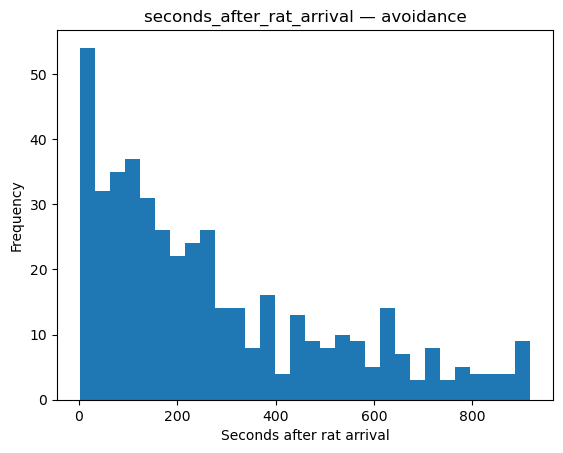

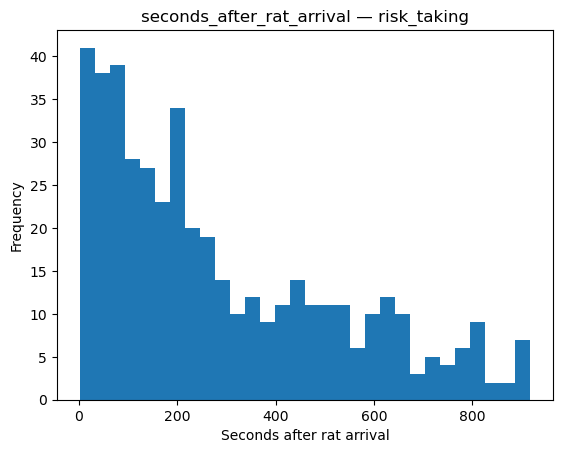

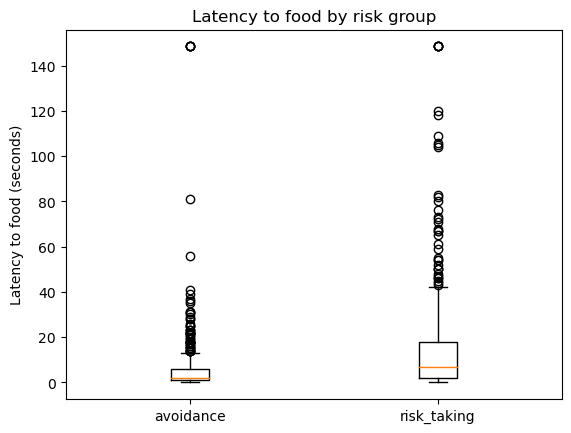

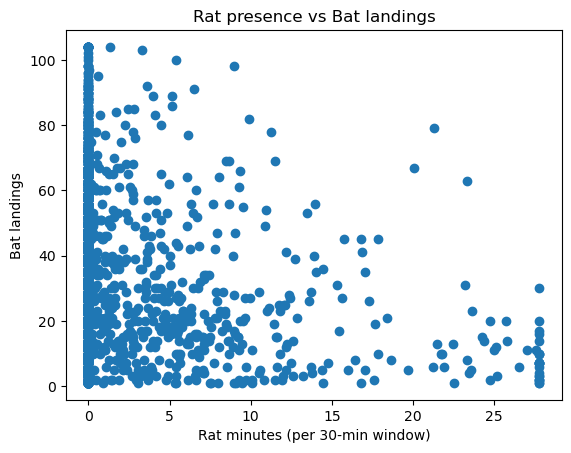

In [44]:

# Histogram: seconds_after_rat_arrival by risk group
if {"seconds_after_rat_arrival", "risk_label"}.issubset(df1.columns):
    for label, g in df1.groupby("risk_label"):
        g["seconds_after_rat_arrival"].dropna().plot(
            kind="hist", bins=30, title=f"seconds_after_rat_arrival — {label}"
        )
        plt.xlabel("Seconds after rat arrival")
        plt.show()

# Boxplot: latency to food by risk
if {"bat_landing_to_food", "risk_label"}.issubset(df1.columns):
    groups = [df1.loc[df1["risk_label"] == lab, "bat_landing_to_food"].dropna()
              for lab in ["avoidance", "risk_taking"] if lab in df1["risk_label"].unique()]
    if len(groups) >= 2:
        plt.boxplot(groups, labels=["avoidance", "risk_taking"][:len(groups)])
        plt.ylabel("Latency to food (seconds)")
        plt.title("Latency to food by risk group")
        plt.show()

# Scatter: rat_minutes vs bat_landing_number
if {"rat_minutes", "bat_landing_number"}.issubset(df2.columns):
    plt.scatter(df2["rat_minutes"], df2["bat_landing_number"])
    plt.xlabel("Rat minutes (per 30-min window)")
    plt.ylabel("Bat landings")
    plt.title("Rat presence vs Bat landings")
    plt.show()


## 8. Final Research Question

**Do bats treat rats as competitors only, or also as predators?**

This section links the hypothesis tests back to the main research objective.

In [45]:
print("Research Question:")
print("Do bats treat rats as competitors only, or also as predators?\n")

print("Summary of Evidence:")
print(f"- H1 (landing time vs risk): p = {results_df.loc[0, 'p_value_formatted']} → Not significant.")
print(f"- H2 (latency to food vs risk): p = {results_df.loc[1, 'p_value_formatted']} → Significant, avoidance bats take longer.")
print(f"- H3 (risk × reward): p = {results_df.loc[2, 'p_value_formatted']} → Significant, risk-taking bats rewarded more.")
print(f"- H4 (rat minutes vs landings): p = {results_df.loc[3, 'p_value_formatted']} → Significant, more rats = fewer bat landings.\n")

print("Interpretation:")
print("- Overall, H2, H3, and H4 all show strong predator-like effects (longer latency, fewer landings, reward trade-off).")
print("- Only H1 was not significant, meaning landing time relative to rat arrival did not differ by risk group.\n")

print("Conclusion:")
print("The evidence supports that bats treat rats not only as competitors for food,")
print("but also as potential predators (predation risk).")


Research Question:
Do bats treat rats as competitors only, or also as predators?

Summary of Evidence:
- H1 (landing time vs risk): p = 0.439 → Not significant.
- H2 (latency to food vs risk): p = 9.30e-19 → Significant, avoidance bats take longer.
- H3 (risk × reward): p = 1.60e-78 → Significant, risk-taking bats rewarded more.
- H4 (rat minutes vs landings): p = 1.77e-07 → Significant, more rats = fewer bat landings.

Interpretation:
- Overall, H2, H3, and H4 all show strong predator-like effects (longer latency, fewer landings, reward trade-off).
- Only H1 was not significant, meaning landing time relative to rat arrival did not differ by risk group.

Conclusion:
The evidence supports that bats treat rats not only as competitors for food,
but also as potential predators (predation risk).
